# Convolutional Neural Networks

So far we have been treating images as flattened arrays of data. One might argue that such representation is not the best, since by flattening 2D images we are losing all spatial information. Let's now use a different network that exploits spatial information by using convolutional layers.

In [1]:
import matplotlib.pyplot as plt  
%matplotlib inline
from utils import plot_samples, plot_curves
import time

Using TensorFlow backend.


In [2]:
import numpy as np
# force random seed for results to be reproducible
SEED = 4242
np.random.seed(SEED)

## Part 1: MNIST

In the first part of this session we will use MNIST data to train the network. Using fully connected layers we achieved an accuracy of nearly 0.98 on the test set. Let's see if we can improve this with convolutional layers.

In [3]:
from keras.datasets import mnist
from keras.utils import np_utils

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

img_rows = X_train.shape[1]
img_cols = X_train.shape[2]

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')


nb_classes = 10
# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

('X_train shape:', (60000, 28, 28, 1))
(60000, 'train samples')
(10000, 'test samples')


**Exercise**: Design a model with [convolutional layers](https://keras.io/layers/convolutional/#convolution2d) for MNIST classification.


You may also need to use other layer types:

```python
keras.layers.pooling.MaxPooling2D(pool_size=(2, 2), border_mode='valid')
keras.layers.core.Flatten()
```


**Answer:**

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import Convolution2D, MaxPooling2D, Flatten


# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3,3)

model = Sequential()
model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1],
                        border_mode='same',
                        input_shape=input_shape))

model.add(Activation('relu'))
model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1],border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 28, 28, 32)    320         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 28, 28, 32)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 28, 28, 32)    9248        activation_1[0][0]               
____________________________________________________________________________________________________
activation_2 (Activation)        (None, 28, 28, 32)    0           convolution2d_2[0][0]            
___________________________________________________________________________________________

**Exercise**: Calculate the number of parameters of the new network. 

**Answer:**

In [5]:
krnl = 3
image_channels = 1
conv_filters = 32
pool = 2
im_size = 28
dense_dim = 128
classes = 10


conv1 = (krnl*krnl*image_channels*conv_filters + conv_filters)
conv2 = (krnl*krnl*conv_filters*conv_filters + conv_filters)
dense1 = ((im_size/2)**2)*conv_filters*dense_dim + dense_dim
cls = dense_dim*classes+classes

print (conv1,conv2,dense1,cls)
conv1+conv2+dense1+cls

320 9248 802944 1290


813802

**Exercise**: The convolutional layer in keras has a parameter ```border_mode```, which can take values of 'valid' (no padding) or 'same' (+padding). What is the impact in the parameters when setting it to  'valid' or 'same', respectively? Why does the number of parameters change?

**Answer:** Adding padding makes the output of the convolution the same size as the input. If no additional pooling layers are added, this makes the output of the layer before the ```Dense``` layer (the one with the highest number of parameters due to dense connectivity) bigger than when we don't add padding, thus increasing the total number of parameters of the network.

Let's train the model:

In [6]:
from keras.optimizers import SGD
lr = 0.01
# For now we will not decrease the learning rate
decay = 0

optim = SGD(lr=lr, decay=decay, momentum=0.9, nesterov=True)

161.576382875 seconds.
----------
Loss: 0.031532
Accuracy: 0.990800


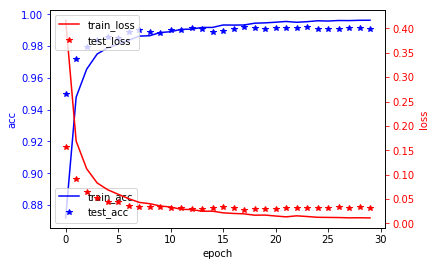

In [7]:
batch_size = 128
nb_epoch = 30
verbose = 0

model.compile(loss='categorical_crossentropy',
              optimizer=optim,
              metrics=['accuracy'])
t = time.time()
# GeForce GTX 980 - 161 seconds 30 epochs bs 128
# GeForce GTX Titan Black - 200 seconds 30 epochs bs 128
history = model.fit(X_train, Y_train,
                batch_size=batch_size, nb_epoch=nb_epoch,
                verbose=verbose,validation_data=(X_test, Y_test))
print (time.time() - t, "seconds.")

score = model.evaluate(X_test, Y_test, verbose=0)
print ("-"*10)
print ("Loss: %f"%(score[0]))
print ("Accuracy: %f"%(score[1]))
plot_curves(history,nb_epoch)

In [8]:
model.save('../models/mnist_conv.h5')

## Part 2: CIFAR

At this point we already know how to train a convnet for classification. Let's now switch to a more challenging dataset of colour images: CIFAR 10.

In [9]:
from keras.datasets import cifar10
import numpy as np
np.random.seed(4242)

Let's load the dataset and display some samples:

('X_train shape:', (50000, 32, 32, 3))
(50000, 'train samples')
(10000, 'test samples')


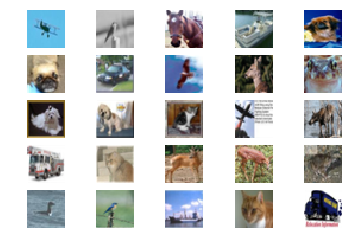

In [10]:
# The data, shuffled and split between train and test sets:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

plot_samples(X_train,5)

We format the data before training:

In [11]:
nb_classes = 10
# Convert class vectors to binary class matrices.
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

X_train.shape
img_rows = X_train.shape[1]
img_cols = X_train.shape[2]
input_shape = (img_rows, img_cols,3)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

input_shape

(32, 32, 3)

**Exercise:** Design and train a convnet to classify cifar 10 images. Hint: Images now have 3 channels instead of 1 !

**Answer:**

In [12]:
n_filters = 32
f_size = 3
p_size = 2
dp_ratio = 0.5
dense_dim = 128

model = Sequential()

model.add(Convolution2D(n_filters, f_size, f_size, border_mode='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(Convolution2D(n_filters, f_size, f_size, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(p_size, p_size)))
model.add(Dropout(dp_ratio))

model.add(Convolution2D(n_filters*2, f_size, f_size, border_mode='same'))
model.add(Activation('relu'))
model.add(Convolution2D(n_filters*2, f_size, f_size, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(p_size, p_size)))
model.add(Dropout(dp_ratio))

model.add(Flatten())
model.add(Dense(dense_dim))
model.add(Activation('relu'))
model.add(Dropout(dp_ratio))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_3 (Convolution2D)  (None, 32, 32, 32)    896         convolution2d_input_2[0][0]      
____________________________________________________________________________________________________
activation_5 (Activation)        (None, 32, 32, 32)    0           convolution2d_3[0][0]            
____________________________________________________________________________________________________
convolution2d_4 (Convolution2D)  (None, 32, 32, 32)    9248        activation_5[0][0]               
____________________________________________________________________________________________________
activation_6 (Activation)        (None, 32, 32, 32)    0           convolution2d_4[0][0]            
___________________________________________________________________________________________

**Exercise**: Calculate the number of parameters of the model. Take into account that max pooling layers and convolutional layers without padding have smaller outputs.

**Answer:**

In [13]:
f_size = 3
conv1 = f_size*f_size*3*32 + 32
conv2 = f_size*f_size*32*32 + 32
conv3 = f_size*f_size*32*64 + 64
conv4 = f_size*f_size*64*64 + 64
dense = 8*8*64*128 + 128
cls = 128*10+10

conv1+conv2+conv3+conv4+dense+cls

591274

In [14]:
batch_size=256
nb_epoch=120
lr = 0.01
decay = 1e-6

optim = SGD(lr=lr, decay=decay, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy',
              optimizer=optim,
              metrics=['accuracy'])
t = time.time()
# 11s/epoch on Titan Black (6GB)
# 5s/epoch titan x (12gb)
history = model.fit(X_train, Y_train,
                batch_size=batch_size, nb_epoch=nb_epoch,
                verbose=0,validation_data=(X_test, Y_test))

print (time.time() - t, 'seconds.')

(867.06685090065, 'seconds.')


Loss: 0.561846
Accuracy: 0.808400


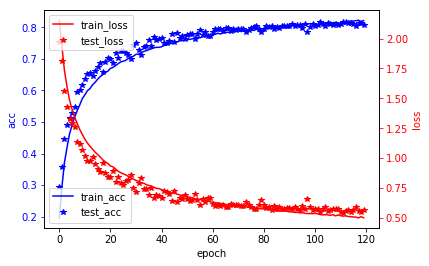

In [15]:
score = model.evaluate(X_test, Y_test, verbose=0)
print ("Loss: %f"%(score[0]))
print ("Accuracy: %f"%(score[1]))
plot_curves(history,nb_epoch)

In [16]:
model.save('../models/cifar10.h5')